<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [2]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

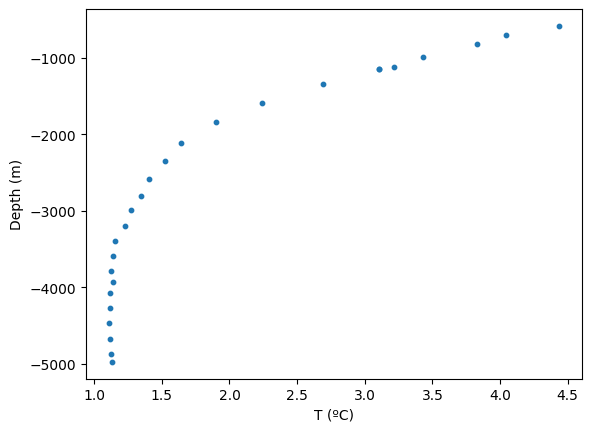

In [3]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2025-11-10 11:30:44,953 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


Text(0, 0.5, 'Depth (m)')

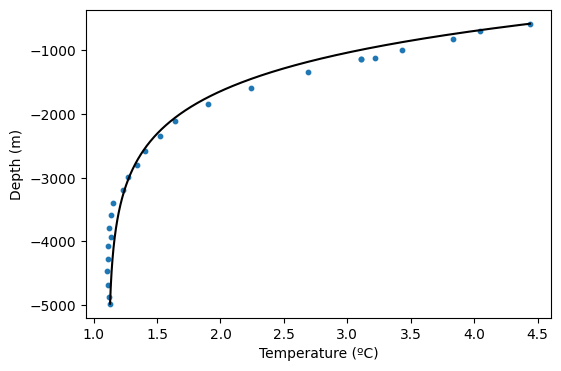

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa= 8e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

original= K=1e_7 after iterations found 8e-5 to be the best fit. this is almost 3 orders of magnitude higher than that predicted by the molecular level alone. this suggests that the mollecular level diffusion is insignificant in the process of heat transport in the ocean in comparison to the role of turbulence.
With K=8e-5, the model predicts the behaviour fairly well but it still smooths the behaviour. it fails to represent the near-isothermal behaviour of the very deep ocean and the shoudler of the curve is at a slightly lower depth, resulting in an overestimate of surface temperatures by up to half a degree.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


2025-11-10 11:30:45,598 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


Text(0, 0.5, 'Depth (m)')

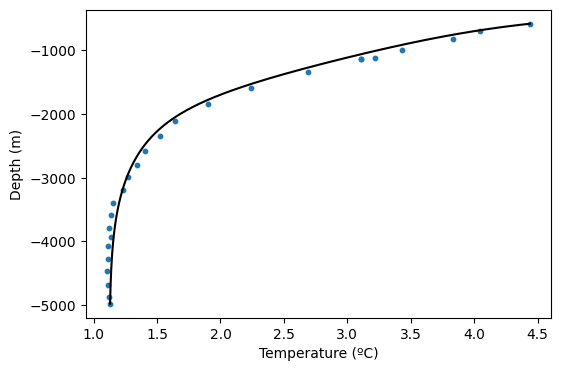

In [5]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 2e-9 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=0.2*(1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

for w=0, the advection-diffusion equation implies that dK/dz=0 ie that the diffusivity is set at the backgrund diffusivity.

If w=0, $$\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$= (expand by product rule)=0 so both terms in derivative must balance

thermal flux= -k dT/dz
k(z)dT/dz must be a constant ie large flux implies small k. iinitally, dt/dz is very large  implies small k, then as dt/dz decreases k will increase. ie temp flux is linked to diffusivity.

best fit w = 1e-8
varying k:
when we mulitplied K by 5, the solution became less accurate. we had to multiply our w by 5 to get a best fit model. similarly, when k was reduced by a factor of 5 the best fit w was 0.2 of that used in the initial condition. ie 2e-9. this implied that w varies linearly with the value of k so w and k are very closely related. physically this means that the downwelling velcoity will vary in parts of the ocean with different diffusivities ie different topographies.



## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [6]:
"""
Script to solve the time-dependent advection/diffusion equation
"""


import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2025-11-10 11:30:46,135 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:30:46,142 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:30:46,808 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:30:46,838 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:30:46,868 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:30:46,898 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:30:46,928 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:30:46,958 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:30:46,988 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:30:47,018 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:30:47,053 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:30:47,100 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:30:47,134 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:30:47,165 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:30:47,203 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:30:47,240 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:30:47,272 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:30:47,304 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:30:47,335 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:30:47,364 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:30:47,397 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:30:47,428 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:30:47,461 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:30:47,491 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:30:47,521 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:30:47,552 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:30:47,587 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:30:47,620 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:30:47,653 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:30:47,683 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:30:47,713 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:30:47,743 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:30:47,774 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:30:47,809 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:30:47,840 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:30:47,872 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:30:47,915 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:30:47,947 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:30:47,977 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:30:48,011 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:30:48,041 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:30:48,071 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:30:48,110 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:30:48,153 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:30:48,187 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:30:48,224 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:30:48,260 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:30:48,292 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:30:48,323 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:30:48,360 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:30:48,395 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:30:48,430 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:30:48,462 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:30:48,491 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:30:48,522 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:30:48,551 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:30:48,584 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:30:48,613 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:30:48,642 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:30:48,673 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:30:48,706 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:30:48,734 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:30:48,764 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:30:48,794 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:30:48,824 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:30:48,854 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:30:48,888 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:30:48,919 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:30:48,949 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:30:48,981 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:30:49,009 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:30:49,038 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:30:49,069 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:30:49,100 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:30:49,132 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:30:49,175 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:30:49,213 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:30:49,250 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:30:49,278 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:30:49,302 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:30:49,304 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:30:49,306 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3374 sec


2025-11-10 11:30:49,308 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3374 sec


INFO:solvers:Warmup time (iter 0-10): 0.6916 sec


2025-11-10 11:30:49,309 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6916 sec


INFO:solvers:Run time (iter 10-end): 2.469 sec


2025-11-10 11:30:49,312 solvers 0/1 INFO :: Run time (iter 10-end): 2.469 sec


INFO:solvers:CPU time (iter 10-end): 0.0006857 cpu-hr


2025-11-10 11:30:49,313 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006857 cpu-hr


INFO:solvers:Speed: 5.324e+06 mode-stages/cpu-sec


2025-11-10 11:30:49,315 solvers 0/1 INFO :: Speed: 5.324e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 11:30:49,553 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnxrahoko/temp.m4v


2025-11-10 11:30:49,556 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpnxrahoko/temp.m4v


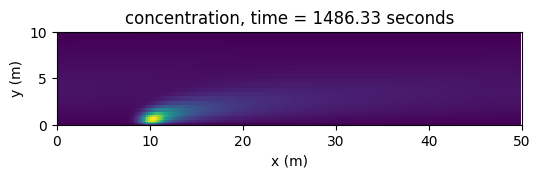

In [7]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

In [8]:
# ADD YOUR CODE HERE
print(c_save.shape)


(78, 256, 32)


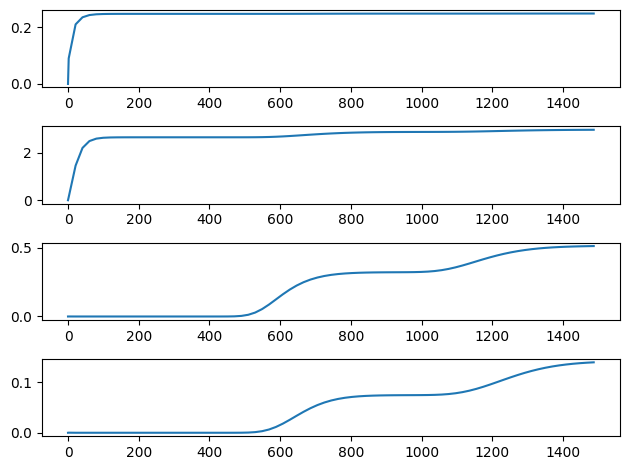

In [9]:
plt.figure()
plt.subplot(4,1,1)
plt.plot(t_save,c_save[:,50,0])

plt.subplot(4,1,2)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(4,1,3)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(4,1,4)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2025-11-10 11:31:13,617 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:31:13,623 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2025-11-10 11:31:13,664 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2025-11-10 11:31:13,694 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2025-11-10 11:31:13,725 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2025-11-10 11:31:13,755 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2025-11-10 11:31:13,787 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2025-11-10 11:31:13,820 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2025-11-10 11:31:13,850 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2025-11-10 11:31:13,884 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2025-11-10 11:31:13,919 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2025-11-10 11:31:13,949 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2025-11-10 11:31:13,981 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2025-11-10 11:31:14,012 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2025-11-10 11:31:14,042 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2025-11-10 11:31:14,073 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2025-11-10 11:31:14,105 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2025-11-10 11:31:14,134 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2025-11-10 11:31:14,166 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2025-11-10 11:31:14,203 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2025-11-10 11:31:14,234 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2025-11-10 11:31:14,266 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2025-11-10 11:31:14,298 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2025-11-10 11:31:14,332 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2025-11-10 11:31:14,364 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2025-11-10 11:31:14,399 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2025-11-10 11:31:14,429 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2025-11-10 11:31:14,471 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2025-11-10 11:31:14,509 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2025-11-10 11:31:14,541 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2025-11-10 11:31:14,583 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2025-11-10 11:31:14,620 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2025-11-10 11:31:14,652 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2025-11-10 11:31:14,683 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2025-11-10 11:31:14,715 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2025-11-10 11:31:14,745 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2025-11-10 11:31:14,774 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2025-11-10 11:31:14,807 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2025-11-10 11:31:14,837 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2025-11-10 11:31:14,870 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2025-11-10 11:31:14,911 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2025-11-10 11:31:14,941 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2025-11-10 11:31:14,977 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2025-11-10 11:31:15,006 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2025-11-10 11:31:15,036 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2025-11-10 11:31:15,066 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2025-11-10 11:31:15,096 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2025-11-10 11:31:15,127 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2025-11-10 11:31:15,158 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2025-11-10 11:31:15,189 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2025-11-10 11:31:15,219 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2025-11-10 11:31:15,252 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2025-11-10 11:31:15,284 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2025-11-10 11:31:15,314 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2025-11-10 11:31:15,344 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2025-11-10 11:31:15,374 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2025-11-10 11:31:15,406 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2025-11-10 11:31:15,439 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2025-11-10 11:31:15,472 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2025-11-10 11:31:15,506 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2025-11-10 11:31:15,538 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2025-11-10 11:31:15,569 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2025-11-10 11:31:15,600 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2025-11-10 11:31:15,643 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2025-11-10 11:31:15,679 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2025-11-10 11:31:15,708 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2025-11-10 11:31:15,737 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2025-11-10 11:31:15,770 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2025-11-10 11:31:15,803 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2025-11-10 11:31:15,833 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2025-11-10 11:31:15,865 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2025-11-10 11:31:15,898 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2025-11-10 11:31:15,932 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2025-11-10 11:31:15,961 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2025-11-10 11:31:15,992 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2025-11-10 11:31:16,030 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2025-11-10 11:31:16,064 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2025-11-10 11:31:16,095 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2025-11-10 11:31:16,128 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2025-11-10 11:31:16,160 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2025-11-10 11:31:16,193 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2025-11-10 11:31:16,222 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2025-11-10 11:31:16,251 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2025-11-10 11:31:16,285 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2025-11-10 11:31:16,315 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2025-11-10 11:31:16,346 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2025-11-10 11:31:16,375 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2025-11-10 11:31:16,405 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2025-11-10 11:31:16,434 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2025-11-10 11:31:16,467 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2025-11-10 11:31:16,498 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2025-11-10 11:31:16,531 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2025-11-10 11:31:16,563 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2025-11-10 11:31:16,592 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2025-11-10 11:31:16,624 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2025-11-10 11:31:16,658 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2025-11-10 11:31:16,697 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2025-11-10 11:31:16,731 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2025-11-10 11:31:16,761 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2025-11-10 11:31:16,793 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2025-11-10 11:31:16,822 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2025-11-10 11:31:16,852 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2025-11-10 11:31:16,886 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2025-11-10 11:31:16,918 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2025-11-10 11:31:16,946 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2025-11-10 11:31:16,976 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2025-11-10 11:31:17,007 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2025-11-10 11:31:17,042 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2025-11-10 11:31:17,075 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2025-11-10 11:31:17,106 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2025-11-10 11:31:17,146 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2025-11-10 11:31:17,177 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2025-11-10 11:31:17,211 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2025-11-10 11:31:17,242 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2025-11-10 11:31:17,273 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2025-11-10 11:31:17,306 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2025-11-10 11:31:17,335 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2025-11-10 11:31:17,366 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2025-11-10 11:31:17,396 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2025-11-10 11:31:17,428 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2025-11-10 11:31:17,461 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2025-11-10 11:31:17,493 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2025-11-10 11:31:17,524 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2025-11-10 11:31:17,555 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2025-11-10 11:31:17,584 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2025-11-10 11:31:17,617 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2025-11-10 11:31:17,648 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2025-11-10 11:31:17,679 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2025-11-10 11:31:17,711 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2025-11-10 11:31:17,757 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2025-11-10 11:31:17,792 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2025-11-10 11:31:17,829 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2025-11-10 11:31:17,859 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2025-11-10 11:31:17,893 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2025-11-10 11:31:17,930 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2025-11-10 11:31:17,960 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2025-11-10 11:31:17,991 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2025-11-10 11:31:18,026 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2025-11-10 11:31:18,061 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2025-11-10 11:31:18,097 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2025-11-10 11:31:18,128 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2025-11-10 11:31:18,161 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2025-11-10 11:31:18,196 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2025-11-10 11:31:18,228 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2025-11-10 11:31:18,259 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2025-11-10 11:31:18,291 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2025-11-10 11:31:18,324 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2025-11-10 11:31:18,356 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2025-11-10 11:31:18,387 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2025-11-10 11:31:18,424 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2025-11-10 11:31:18,456 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2025-11-10 11:31:18,489 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2025-11-10 11:31:18,521 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2025-11-10 11:31:18,551 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2025-11-10 11:31:18,583 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2025-11-10 11:31:18,615 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2025-11-10 11:31:18,635 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2025-11-10 11:31:18,638 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:31:18,640 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5347 sec


2025-11-10 11:31:18,644 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5347 sec


INFO:solvers:Warmup time (iter 0-10): 0.06749 sec


2025-11-10 11:31:18,647 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06749 sec


INFO:solvers:Run time (iter 10-end): 4.946 sec


2025-11-10 11:31:18,649 solvers 0/1 INFO :: Run time (iter 10-end): 4.946 sec


INFO:solvers:CPU time (iter 10-end): 0.001374 cpu-hr


2025-11-10 11:31:18,652 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001374 cpu-hr


INFO:solvers:Speed: 5.35e+06 mode-stages/cpu-sec


2025-11-10 11:31:18,653 solvers 0/1 INFO :: Speed: 5.35e+06 mode-stages/cpu-sec


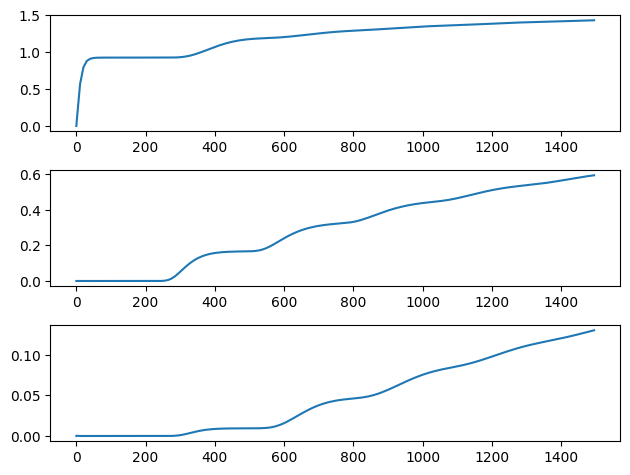

In [10]:

# Set parameters
U0 = 0.2 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure()

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


2025-11-10 11:31:19,619 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:31:19,625 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:31:19,678 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:31:19,719 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:31:19,760 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:31:19,801 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:31:19,846 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:31:19,893 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:31:19,948 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:31:19,994 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:31:20,038 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:31:20,080 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:31:20,120 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:31:20,159 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:31:20,204 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:31:20,247 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:31:20,286 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:31:20,326 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:31:20,368 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:31:20,409 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:31:20,451 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:31:20,492 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:31:20,537 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:31:20,579 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:31:20,624 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:31:20,672 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:31:20,724 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:31:20,772 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:31:20,819 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:31:20,868 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:31:20,915 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:31:20,963 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:31:21,008 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:31:21,048 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:31:21,095 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:31:21,148 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:31:21,197 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:31:21,247 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:31:21,294 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:31:21,340 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:31:21,387 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:31:21,433 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:31:21,481 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:31:21,526 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:31:21,569 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:31:21,613 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:31:21,660 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:31:21,706 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:31:21,740 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:31:21,770 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:31:21,798 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:31:21,831 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:31:21,861 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:31:21,893 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:31:21,923 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:31:21,953 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:31:21,985 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:31:22,017 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:31:22,061 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:31:22,097 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:31:22,128 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:31:22,158 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:31:22,191 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:31:22,218 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:31:22,248 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:31:22,279 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:31:22,307 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:31:22,337 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:31:22,369 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:31:22,398 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:31:22,428 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:31:22,459 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:31:22,490 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:31:22,522 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:31:22,552 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:31:22,582 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:31:22,613 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:31:22,646 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:31:22,677 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:31:22,702 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:31:22,704 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:31:22,707 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3947 sec


2025-11-10 11:31:22,712 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3947 sec


INFO:solvers:Warmup time (iter 0-10): 0.08835 sec


2025-11-10 11:31:22,717 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08835 sec


INFO:solvers:Run time (iter 10-end): 2.988 sec


2025-11-10 11:31:22,719 solvers 0/1 INFO :: Run time (iter 10-end): 2.988 sec


INFO:solvers:CPU time (iter 10-end): 0.0008301 cpu-hr


2025-11-10 11:31:22,720 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0008301 cpu-hr


INFO:solvers:Speed: 4.398e+06 mode-stages/cpu-sec


2025-11-10 11:31:22,722 solvers 0/1 INFO :: Speed: 4.398e+06 mode-stages/cpu-sec


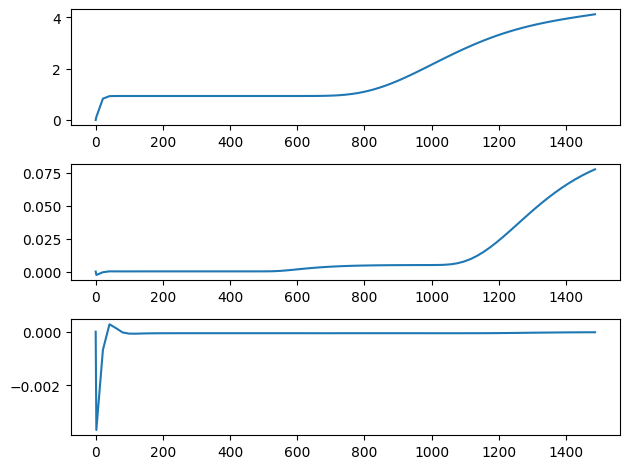

In [11]:
# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-3 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure()

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])

plt.tight_layout()

plt.show()

ADD DISCUSSION HERE

from green book
for x direction use fact that advection dominates over diffusion as seen in videa

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

INSERT PLOTS AND COMMENTS HERE


In [19]:
#solving diffusion equation for fluctuatung velocity field
#change c notation?

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
#u['g'] = u(x,y,k)
#v['g'] = v(x,y,k)
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2025-11-10 11:34:16,911 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:34:16,917 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-10 11:34:17,105 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-10 11:34:17,185 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-10 11:34:17,275 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-10 11:34:17,352 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-10 11:34:17,430 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-10 11:34:17,508 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-10 11:34:17,589 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-10 11:34:17,664 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-10 11:34:17,753 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-10 11:34:17,833 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-10 11:34:17,913 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-10 11:34:17,995 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-10 11:34:18,090 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-10 11:34:18,175 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-10 11:34:18,253 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-10 11:34:18,329 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-10 11:34:18,405 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-10 11:34:18,481 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-10 11:34:18,558 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-10 11:34:18,632 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-10 11:34:18,705 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-10 11:34:18,792 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-10 11:34:18,867 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-10 11:34:18,948 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-10 11:34:19,026 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-10 11:34:19,107 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-10 11:34:19,183 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-10 11:34:19,256 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-10 11:34:19,331 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-10 11:34:19,402 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-10 11:34:19,476 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-10 11:34:19,553 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-10 11:34:19,624 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-10 11:34:19,700 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-10 11:34:19,773 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-10 11:34:19,862 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-10 11:34:19,939 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-10 11:34:20,015 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-10 11:34:20,091 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-10 11:34:20,166 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-10 11:34:20,240 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-10 11:34:20,318 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-10 11:34:20,390 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-10 11:34:20,464 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-10 11:34:20,539 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-10 11:34:20,617 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-10 11:34:20,694 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-10 11:34:20,769 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-10 11:34:20,851 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-10 11:34:20,933 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-10 11:34:21,007 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-10 11:34:21,083 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-10 11:34:21,161 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-10 11:34:21,240 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-10 11:34:21,314 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-10 11:34:21,391 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-10 11:34:21,466 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-10 11:34:21,544 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-10 11:34:21,618 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-10 11:34:21,691 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-10 11:34:21,767 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-10 11:34:21,845 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-10 11:34:21,936 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-10 11:34:22,016 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-10 11:34:22,096 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-10 11:34:22,174 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-10 11:34:22,251 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-10 11:34:22,326 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-10 11:34:22,402 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-10 11:34:22,475 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-10 11:34:22,554 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-10 11:34:22,628 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-10 11:34:22,708 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-10 11:34:22,791 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-10 11:34:22,869 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-10 11:34:22,954 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-10 11:34:23,034 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-10 11:34:23,088 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-10 11:34:23,090 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:34:23,096 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5979 sec


2025-11-10 11:34:23,099 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5979 sec


INFO:solvers:Warmup time (iter 0-10): 0.2585 sec


2025-11-10 11:34:23,103 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2585 sec


INFO:solvers:Run time (iter 10-end): 5.913 sec


2025-11-10 11:34:23,106 solvers 0/1 INFO :: Run time (iter 10-end): 5.913 sec


INFO:solvers:CPU time (iter 10-end): 0.001643 cpu-hr


2025-11-10 11:34:23,110 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001643 cpu-hr


INFO:solvers:Speed: 2.223e+06 mode-stages/cpu-sec


2025-11-10 11:34:23,113 solvers 0/1 INFO :: Speed: 2.223e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 11:31:29,504 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpqjc53pqx/temp.m4v


2025-11-10 11:31:29,507 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpqjc53pqx/temp.m4v


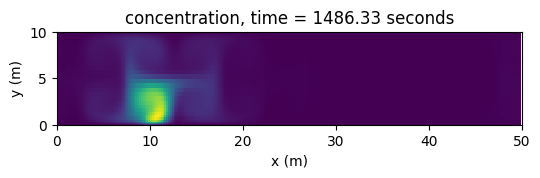

In [13]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

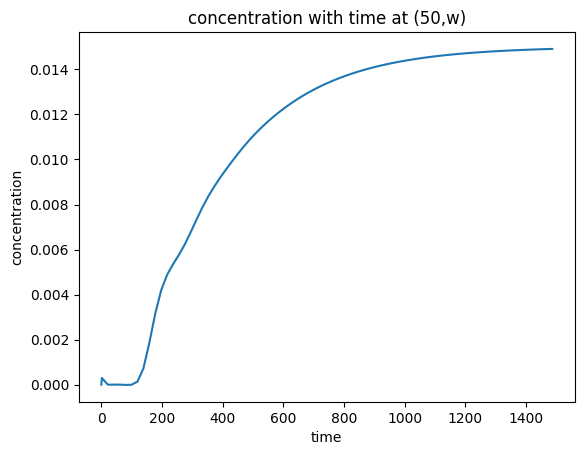

In [14]:
plt.figure()

plt.plot(t_save,c_save[:,50,-1])
plt.title('concentration with time at (50,w)')
plt.xlabel('time')
plt.ylabel('concentration')

plt.show()

In [15]:
#cycle through all time and space systematically at y=w to find first time and first point of non-zero conc
#c_save= [t,x,y] t only up to 78
for t in range (1000):
  for x in range (Nx):
    if c_save[t,x,w] > 0:
      print ('particle found at time = t, distance = x')
    else:
if c_save[t, Nx, w] ==0:
  t=t+1
if c_save[t,x,w] > 0:
  print ('particle found at time = t, distance = x')

#try numpy.nonzero to find index of first nonzero element

IndentationError: expected an indented block after 'else' statement on line 7 (ipython-input-1713766758.py, line 8)

In [20]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 1.953125 s, distance = 3.515625m


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2025-11-10 11:32:00,325 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:32:00,332 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2025-11-10 11:32:00,483 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2025-11-10 11:32:00,558 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2025-11-10 11:32:00,645 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2025-11-10 11:32:00,721 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2025-11-10 11:32:00,797 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2025-11-10 11:32:00,869 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2025-11-10 11:32:00,944 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2025-11-10 11:32:01,020 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2025-11-10 11:32:01,094 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2025-11-10 11:32:01,167 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2025-11-10 11:32:01,243 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2025-11-10 11:32:01,321 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2025-11-10 11:32:01,395 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2025-11-10 11:32:01,467 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2025-11-10 11:32:01,539 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2025-11-10 11:32:01,616 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2025-11-10 11:32:01,701 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2025-11-10 11:32:01,776 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2025-11-10 11:32:01,853 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2025-11-10 11:32:01,928 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2025-11-10 11:32:02,004 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2025-11-10 11:32:02,078 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2025-11-10 11:32:02,153 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2025-11-10 11:32:02,235 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2025-11-10 11:32:02,307 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2025-11-10 11:32:02,381 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2025-11-10 11:32:02,456 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2025-11-10 11:32:02,530 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2025-11-10 11:32:02,609 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2025-11-10 11:32:02,696 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2025-11-10 11:32:02,781 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2025-11-10 11:32:02,858 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2025-11-10 11:32:02,932 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2025-11-10 11:32:03,012 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2025-11-10 11:32:03,093 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2025-11-10 11:32:03,169 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2025-11-10 11:32:03,243 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2025-11-10 11:32:03,321 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2025-11-10 11:32:03,396 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2025-11-10 11:32:03,471 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2025-11-10 11:32:03,547 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2025-11-10 11:32:03,620 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2025-11-10 11:32:03,702 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2025-11-10 11:32:03,782 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2025-11-10 11:32:03,855 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2025-11-10 11:32:03,930 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2025-11-10 11:32:04,004 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2025-11-10 11:32:04,076 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2025-11-10 11:32:04,148 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2025-11-10 11:32:04,221 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2025-11-10 11:32:04,301 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2025-11-10 11:32:04,379 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2025-11-10 11:32:04,453 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2025-11-10 11:32:04,525 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2025-11-10 11:32:04,738 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2025-11-10 11:32:04,963 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2025-11-10 11:32:05,075 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2025-11-10 11:32:05,154 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2025-11-10 11:32:05,230 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2025-11-10 11:32:05,309 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2025-11-10 11:32:05,387 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2025-11-10 11:32:05,469 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2025-11-10 11:32:05,570 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2025-11-10 11:32:05,886 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2025-11-10 11:32:05,983 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2025-11-10 11:32:06,054 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2025-11-10 11:32:06,126 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2025-11-10 11:32:06,198 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2025-11-10 11:32:06,276 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2025-11-10 11:32:06,347 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2025-11-10 11:32:06,422 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2025-11-10 11:32:06,495 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2025-11-10 11:32:06,569 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2025-11-10 11:32:06,642 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2025-11-10 11:32:06,714 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2025-11-10 11:32:06,788 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2025-11-10 11:32:06,886 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2025-11-10 11:32:06,960 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2025-11-10 11:32:07,039 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2025-11-10 11:32:07,121 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2025-11-10 11:32:07,198 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2025-11-10 11:32:07,276 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2025-11-10 11:32:07,355 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2025-11-10 11:32:07,430 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2025-11-10 11:32:07,505 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2025-11-10 11:32:07,581 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2025-11-10 11:32:07,652 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2025-11-10 11:32:07,727 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2025-11-10 11:32:07,800 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2025-11-10 11:32:07,873 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2025-11-10 11:32:07,958 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2025-11-10 11:32:08,032 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2025-11-10 11:32:08,105 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2025-11-10 11:32:08,180 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2025-11-10 11:32:08,258 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2025-11-10 11:32:08,338 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2025-11-10 11:32:08,413 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2025-11-10 11:32:08,487 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2025-11-10 11:32:08,560 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2025-11-10 11:32:08,639 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2025-11-10 11:32:08,715 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2025-11-10 11:32:08,791 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2025-11-10 11:32:08,866 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2025-11-10 11:32:08,952 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2025-11-10 11:32:09,035 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2025-11-10 11:32:09,113 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2025-11-10 11:32:09,220 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2025-11-10 11:32:09,329 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2025-11-10 11:32:09,424 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2025-11-10 11:32:09,519 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2025-11-10 11:32:09,628 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2025-11-10 11:32:09,728 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2025-11-10 11:32:09,828 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2025-11-10 11:32:09,922 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2025-11-10 11:32:10,026 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2025-11-10 11:32:10,137 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2025-11-10 11:32:10,238 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2025-11-10 11:32:10,337 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2025-11-10 11:32:10,432 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2025-11-10 11:32:10,527 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2025-11-10 11:32:10,623 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2025-11-10 11:32:10,719 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2025-11-10 11:32:10,820 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2025-11-10 11:32:10,914 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2025-11-10 11:32:11,022 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2025-11-10 11:32:11,140 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2025-11-10 11:32:11,245 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2025-11-10 11:32:11,342 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2025-11-10 11:32:11,440 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2025-11-10 11:32:11,542 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2025-11-10 11:32:11,647 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2025-11-10 11:32:11,750 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2025-11-10 11:32:11,857 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2025-11-10 11:32:11,950 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2025-11-10 11:32:12,037 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2025-11-10 11:32:12,111 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2025-11-10 11:32:12,191 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2025-11-10 11:32:12,278 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2025-11-10 11:32:12,353 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2025-11-10 11:32:12,427 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2025-11-10 11:32:12,502 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2025-11-10 11:32:12,575 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2025-11-10 11:32:12,648 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2025-11-10 11:32:12,725 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2025-11-10 11:32:12,800 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2025-11-10 11:32:12,878 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2025-11-10 11:32:12,957 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2025-11-10 11:32:13,034 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2025-11-10 11:32:13,115 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2025-11-10 11:32:13,194 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2025-11-10 11:32:13,284 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2025-11-10 11:32:13,361 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2025-11-10 11:32:13,439 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2025-11-10 11:32:13,517 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2025-11-10 11:32:13,559 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2025-11-10 11:32:13,562 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2025-11-10 11:32:13,564 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.7053 sec


2025-11-10 11:32:13,568 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7053 sec


INFO:solvers:Warmup time (iter 0-10): 0.2173 sec


2025-11-10 11:32:13,573 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2173 sec


INFO:solvers:Run time (iter 10-end): 13.01 sec


2025-11-10 11:32:13,577 solvers 0/1 INFO :: Run time (iter 10-end): 13.01 sec


INFO:solvers:CPU time (iter 10-end): 0.003614 cpu-hr


2025-11-10 11:32:13,581 solvers 0/1 INFO :: CPU time (iter 10-end): 0.003614 cpu-hr


INFO:solvers:Speed: 2.034e+06 mode-stages/cpu-sec


2025-11-10 11:32:13,583 solvers 0/1 INFO :: Speed: 2.034e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-10 11:32:13,707 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe9vzhstx/temp.m4v


2025-11-10 11:32:13,708 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpe9vzhstx/temp.m4v


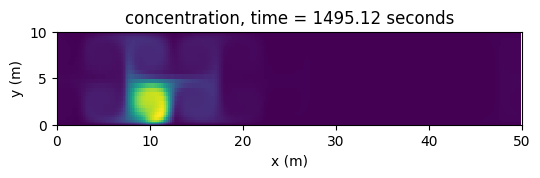

In [16]:
# U=0.2, k=pi/5

# Set parameters
U0 = 0.2 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
#u['g'] = u(x,y,k)
#v['g'] = v(x,y,k)
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)


fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


In [17]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 0.9765625 s, distance = 0.0m


In [24]:
#U0=0.3 k=pi/5
# Set parameters
U0 = 0.3 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2025-11-10 11:39:19,449 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:__main__:Starting main loop


2025-11-10 11:39:19,455 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.510417e-01, dt=6.510417e-01


2025-11-10 11:39:19,603 __main__ 0/1 INFO :: Iteration=1, Time=6.510417e-01, dt=6.510417e-01


INFO:__main__:Iteration=11, Time=7.161458e+00, dt=6.510417e-01


2025-11-10 11:39:19,675 __main__ 0/1 INFO :: Iteration=11, Time=7.161458e+00, dt=6.510417e-01


INFO:__main__:Iteration=21, Time=1.367187e+01, dt=6.510417e-01


2025-11-10 11:39:19,748 __main__ 0/1 INFO :: Iteration=21, Time=1.367187e+01, dt=6.510417e-01


INFO:__main__:Iteration=31, Time=2.018229e+01, dt=6.510417e-01


2025-11-10 11:39:19,823 __main__ 0/1 INFO :: Iteration=31, Time=2.018229e+01, dt=6.510417e-01


INFO:__main__:Iteration=41, Time=2.669271e+01, dt=6.510417e-01


2025-11-10 11:39:19,896 __main__ 0/1 INFO :: Iteration=41, Time=2.669271e+01, dt=6.510417e-01


INFO:__main__:Iteration=51, Time=3.320313e+01, dt=6.510417e-01


2025-11-10 11:39:19,977 __main__ 0/1 INFO :: Iteration=51, Time=3.320313e+01, dt=6.510417e-01


INFO:__main__:Iteration=61, Time=3.971354e+01, dt=6.510417e-01


2025-11-10 11:39:20,054 __main__ 0/1 INFO :: Iteration=61, Time=3.971354e+01, dt=6.510417e-01


INFO:__main__:Iteration=71, Time=4.622396e+01, dt=6.510417e-01


2025-11-10 11:39:20,132 __main__ 0/1 INFO :: Iteration=71, Time=4.622396e+01, dt=6.510417e-01


INFO:__main__:Iteration=81, Time=5.273437e+01, dt=6.510417e-01


2025-11-10 11:39:20,204 __main__ 0/1 INFO :: Iteration=81, Time=5.273437e+01, dt=6.510417e-01


INFO:__main__:Iteration=91, Time=5.924479e+01, dt=6.510417e-01


2025-11-10 11:39:20,279 __main__ 0/1 INFO :: Iteration=91, Time=5.924479e+01, dt=6.510417e-01


INFO:__main__:Iteration=101, Time=6.575521e+01, dt=6.510417e-01


2025-11-10 11:39:20,358 __main__ 0/1 INFO :: Iteration=101, Time=6.575521e+01, dt=6.510417e-01


INFO:__main__:Iteration=111, Time=7.226562e+01, dt=6.510417e-01


2025-11-10 11:39:20,441 __main__ 0/1 INFO :: Iteration=111, Time=7.226562e+01, dt=6.510417e-01


INFO:__main__:Iteration=121, Time=7.877604e+01, dt=6.510417e-01


2025-11-10 11:39:20,521 __main__ 0/1 INFO :: Iteration=121, Time=7.877604e+01, dt=6.510417e-01


INFO:__main__:Iteration=131, Time=8.528646e+01, dt=6.510417e-01


2025-11-10 11:39:20,600 __main__ 0/1 INFO :: Iteration=131, Time=8.528646e+01, dt=6.510417e-01


INFO:__main__:Iteration=141, Time=9.179688e+01, dt=6.510417e-01


2025-11-10 11:39:20,674 __main__ 0/1 INFO :: Iteration=141, Time=9.179688e+01, dt=6.510417e-01


INFO:__main__:Iteration=151, Time=9.830729e+01, dt=6.510417e-01


2025-11-10 11:39:20,752 __main__ 0/1 INFO :: Iteration=151, Time=9.830729e+01, dt=6.510417e-01


INFO:__main__:Iteration=161, Time=1.048177e+02, dt=6.510417e-01


2025-11-10 11:39:20,828 __main__ 0/1 INFO :: Iteration=161, Time=1.048177e+02, dt=6.510417e-01


INFO:__main__:Iteration=171, Time=1.113281e+02, dt=6.510417e-01


2025-11-10 11:39:20,903 __main__ 0/1 INFO :: Iteration=171, Time=1.113281e+02, dt=6.510417e-01


INFO:__main__:Iteration=181, Time=1.178385e+02, dt=6.510417e-01


2025-11-10 11:39:20,982 __main__ 0/1 INFO :: Iteration=181, Time=1.178385e+02, dt=6.510417e-01


INFO:__main__:Iteration=191, Time=1.243490e+02, dt=6.510417e-01


2025-11-10 11:39:21,058 __main__ 0/1 INFO :: Iteration=191, Time=1.243490e+02, dt=6.510417e-01


INFO:__main__:Iteration=201, Time=1.308594e+02, dt=6.510417e-01


2025-11-10 11:39:21,131 __main__ 0/1 INFO :: Iteration=201, Time=1.308594e+02, dt=6.510417e-01


INFO:__main__:Iteration=211, Time=1.373698e+02, dt=6.510417e-01


2025-11-10 11:39:21,202 __main__ 0/1 INFO :: Iteration=211, Time=1.373698e+02, dt=6.510417e-01


INFO:__main__:Iteration=221, Time=1.438802e+02, dt=6.510417e-01


2025-11-10 11:39:21,277 __main__ 0/1 INFO :: Iteration=221, Time=1.438802e+02, dt=6.510417e-01


INFO:__main__:Iteration=231, Time=1.503906e+02, dt=6.510417e-01


2025-11-10 11:39:21,353 __main__ 0/1 INFO :: Iteration=231, Time=1.503906e+02, dt=6.510417e-01


INFO:__main__:Iteration=241, Time=1.569010e+02, dt=6.510417e-01


2025-11-10 11:39:21,433 __main__ 0/1 INFO :: Iteration=241, Time=1.569010e+02, dt=6.510417e-01


INFO:__main__:Iteration=251, Time=1.634115e+02, dt=6.510417e-01


2025-11-10 11:39:21,535 __main__ 0/1 INFO :: Iteration=251, Time=1.634115e+02, dt=6.510417e-01


INFO:__main__:Iteration=261, Time=1.699219e+02, dt=6.510417e-01


2025-11-10 11:39:21,626 __main__ 0/1 INFO :: Iteration=261, Time=1.699219e+02, dt=6.510417e-01


INFO:__main__:Iteration=271, Time=1.764323e+02, dt=6.510417e-01


2025-11-10 11:39:21,734 __main__ 0/1 INFO :: Iteration=271, Time=1.764323e+02, dt=6.510417e-01


INFO:__main__:Iteration=281, Time=1.829427e+02, dt=6.510417e-01


2025-11-10 11:39:21,837 __main__ 0/1 INFO :: Iteration=281, Time=1.829427e+02, dt=6.510417e-01


INFO:__main__:Iteration=291, Time=1.894531e+02, dt=6.510417e-01


2025-11-10 11:39:21,925 __main__ 0/1 INFO :: Iteration=291, Time=1.894531e+02, dt=6.510417e-01


INFO:__main__:Iteration=301, Time=1.959635e+02, dt=6.510417e-01


2025-11-10 11:39:22,009 __main__ 0/1 INFO :: Iteration=301, Time=1.959635e+02, dt=6.510417e-01


INFO:__main__:Iteration=311, Time=2.024740e+02, dt=6.510417e-01


2025-11-10 11:39:22,086 __main__ 0/1 INFO :: Iteration=311, Time=2.024740e+02, dt=6.510417e-01


INFO:__main__:Iteration=321, Time=2.089844e+02, dt=6.510417e-01


2025-11-10 11:39:22,161 __main__ 0/1 INFO :: Iteration=321, Time=2.089844e+02, dt=6.510417e-01


INFO:__main__:Iteration=331, Time=2.154948e+02, dt=6.510417e-01


2025-11-10 11:39:22,238 __main__ 0/1 INFO :: Iteration=331, Time=2.154948e+02, dt=6.510417e-01


INFO:__main__:Iteration=341, Time=2.220052e+02, dt=6.510417e-01


2025-11-10 11:39:22,311 __main__ 0/1 INFO :: Iteration=341, Time=2.220052e+02, dt=6.510417e-01


INFO:__main__:Iteration=351, Time=2.285156e+02, dt=6.510417e-01


2025-11-10 11:39:22,383 __main__ 0/1 INFO :: Iteration=351, Time=2.285156e+02, dt=6.510417e-01


INFO:__main__:Iteration=361, Time=2.350260e+02, dt=6.510417e-01


2025-11-10 11:39:22,457 __main__ 0/1 INFO :: Iteration=361, Time=2.350260e+02, dt=6.510417e-01


INFO:__main__:Iteration=371, Time=2.415365e+02, dt=6.510417e-01


2025-11-10 11:39:22,542 __main__ 0/1 INFO :: Iteration=371, Time=2.415365e+02, dt=6.510417e-01


INFO:__main__:Iteration=381, Time=2.480469e+02, dt=6.510417e-01


2025-11-10 11:39:22,614 __main__ 0/1 INFO :: Iteration=381, Time=2.480469e+02, dt=6.510417e-01


INFO:__main__:Iteration=391, Time=2.545573e+02, dt=6.510417e-01


2025-11-10 11:39:22,691 __main__ 0/1 INFO :: Iteration=391, Time=2.545573e+02, dt=6.510417e-01


INFO:__main__:Iteration=401, Time=2.610677e+02, dt=6.510417e-01


2025-11-10 11:39:22,767 __main__ 0/1 INFO :: Iteration=401, Time=2.610677e+02, dt=6.510417e-01


INFO:__main__:Iteration=411, Time=2.675781e+02, dt=6.510417e-01


2025-11-10 11:39:22,841 __main__ 0/1 INFO :: Iteration=411, Time=2.675781e+02, dt=6.510417e-01


INFO:__main__:Iteration=421, Time=2.740885e+02, dt=6.510417e-01


2025-11-10 11:39:22,914 __main__ 0/1 INFO :: Iteration=421, Time=2.740885e+02, dt=6.510417e-01


INFO:__main__:Iteration=431, Time=2.805990e+02, dt=6.510417e-01


2025-11-10 11:39:22,991 __main__ 0/1 INFO :: Iteration=431, Time=2.805990e+02, dt=6.510417e-01


INFO:__main__:Iteration=441, Time=2.871094e+02, dt=6.510417e-01


2025-11-10 11:39:23,069 __main__ 0/1 INFO :: Iteration=441, Time=2.871094e+02, dt=6.510417e-01


INFO:__main__:Iteration=451, Time=2.936198e+02, dt=6.510417e-01


2025-11-10 11:39:23,144 __main__ 0/1 INFO :: Iteration=451, Time=2.936198e+02, dt=6.510417e-01


INFO:__main__:Iteration=461, Time=3.001302e+02, dt=6.510417e-01


2025-11-10 11:39:23,220 __main__ 0/1 INFO :: Iteration=461, Time=3.001302e+02, dt=6.510417e-01


INFO:__main__:Iteration=471, Time=3.066406e+02, dt=6.510417e-01


2025-11-10 11:39:23,297 __main__ 0/1 INFO :: Iteration=471, Time=3.066406e+02, dt=6.510417e-01


INFO:__main__:Iteration=481, Time=3.131510e+02, dt=6.510417e-01


2025-11-10 11:39:23,373 __main__ 0/1 INFO :: Iteration=481, Time=3.131510e+02, dt=6.510417e-01


INFO:__main__:Iteration=491, Time=3.196615e+02, dt=6.510417e-01


2025-11-10 11:39:23,444 __main__ 0/1 INFO :: Iteration=491, Time=3.196615e+02, dt=6.510417e-01


INFO:__main__:Iteration=501, Time=3.261719e+02, dt=6.510417e-01


2025-11-10 11:39:23,519 __main__ 0/1 INFO :: Iteration=501, Time=3.261719e+02, dt=6.510417e-01


INFO:__main__:Iteration=511, Time=3.326823e+02, dt=6.510417e-01


2025-11-10 11:39:23,605 __main__ 0/1 INFO :: Iteration=511, Time=3.326823e+02, dt=6.510417e-01


INFO:__main__:Iteration=521, Time=3.391927e+02, dt=6.510417e-01


2025-11-10 11:39:23,677 __main__ 0/1 INFO :: Iteration=521, Time=3.391927e+02, dt=6.510417e-01


INFO:__main__:Iteration=531, Time=3.457031e+02, dt=6.510417e-01


2025-11-10 11:39:23,749 __main__ 0/1 INFO :: Iteration=531, Time=3.457031e+02, dt=6.510417e-01


INFO:__main__:Iteration=541, Time=3.522135e+02, dt=6.510417e-01


2025-11-10 11:39:23,825 __main__ 0/1 INFO :: Iteration=541, Time=3.522135e+02, dt=6.510417e-01


INFO:__main__:Iteration=551, Time=3.587240e+02, dt=6.510417e-01


2025-11-10 11:39:23,902 __main__ 0/1 INFO :: Iteration=551, Time=3.587240e+02, dt=6.510417e-01


INFO:__main__:Iteration=561, Time=3.652344e+02, dt=6.510417e-01


2025-11-10 11:39:24,013 __main__ 0/1 INFO :: Iteration=561, Time=3.652344e+02, dt=6.510417e-01


INFO:__main__:Iteration=571, Time=3.717448e+02, dt=6.510417e-01


2025-11-10 11:39:24,119 __main__ 0/1 INFO :: Iteration=571, Time=3.717448e+02, dt=6.510417e-01


INFO:__main__:Iteration=581, Time=3.782552e+02, dt=6.510417e-01


2025-11-10 11:39:24,222 __main__ 0/1 INFO :: Iteration=581, Time=3.782552e+02, dt=6.510417e-01


INFO:__main__:Iteration=591, Time=3.847656e+02, dt=6.510417e-01


2025-11-10 11:39:24,329 __main__ 0/1 INFO :: Iteration=591, Time=3.847656e+02, dt=6.510417e-01


INFO:__main__:Iteration=601, Time=3.912760e+02, dt=6.510417e-01


2025-11-10 11:39:24,430 __main__ 0/1 INFO :: Iteration=601, Time=3.912760e+02, dt=6.510417e-01


INFO:__main__:Iteration=611, Time=3.977865e+02, dt=6.510417e-01


2025-11-10 11:39:24,527 __main__ 0/1 INFO :: Iteration=611, Time=3.977865e+02, dt=6.510417e-01


INFO:__main__:Iteration=621, Time=4.042969e+02, dt=6.510417e-01


2025-11-10 11:39:24,643 __main__ 0/1 INFO :: Iteration=621, Time=4.042969e+02, dt=6.510417e-01


INFO:__main__:Iteration=631, Time=4.108073e+02, dt=6.510417e-01


2025-11-10 11:39:24,739 __main__ 0/1 INFO :: Iteration=631, Time=4.108073e+02, dt=6.510417e-01


INFO:__main__:Iteration=641, Time=4.173177e+02, dt=6.510417e-01


2025-11-10 11:39:24,837 __main__ 0/1 INFO :: Iteration=641, Time=4.173177e+02, dt=6.510417e-01


INFO:__main__:Iteration=651, Time=4.238281e+02, dt=6.510417e-01


2025-11-10 11:39:24,935 __main__ 0/1 INFO :: Iteration=651, Time=4.238281e+02, dt=6.510417e-01


INFO:__main__:Iteration=661, Time=4.303385e+02, dt=6.510417e-01


2025-11-10 11:39:25,033 __main__ 0/1 INFO :: Iteration=661, Time=4.303385e+02, dt=6.510417e-01


INFO:__main__:Iteration=671, Time=4.368490e+02, dt=6.510417e-01


2025-11-10 11:39:25,132 __main__ 0/1 INFO :: Iteration=671, Time=4.368490e+02, dt=6.510417e-01


INFO:__main__:Iteration=681, Time=4.433594e+02, dt=6.510417e-01


2025-11-10 11:39:25,226 __main__ 0/1 INFO :: Iteration=681, Time=4.433594e+02, dt=6.510417e-01


INFO:__main__:Iteration=691, Time=4.498698e+02, dt=6.510417e-01


2025-11-10 11:39:25,315 __main__ 0/1 INFO :: Iteration=691, Time=4.498698e+02, dt=6.510417e-01


INFO:__main__:Iteration=701, Time=4.563802e+02, dt=6.510417e-01


2025-11-10 11:39:25,408 __main__ 0/1 INFO :: Iteration=701, Time=4.563802e+02, dt=6.510417e-01


INFO:__main__:Iteration=711, Time=4.628906e+02, dt=6.510417e-01


2025-11-10 11:39:25,503 __main__ 0/1 INFO :: Iteration=711, Time=4.628906e+02, dt=6.510417e-01


INFO:__main__:Iteration=721, Time=4.694010e+02, dt=6.510417e-01


2025-11-10 11:39:25,593 __main__ 0/1 INFO :: Iteration=721, Time=4.694010e+02, dt=6.510417e-01


INFO:__main__:Iteration=731, Time=4.759115e+02, dt=6.510417e-01


2025-11-10 11:39:25,683 __main__ 0/1 INFO :: Iteration=731, Time=4.759115e+02, dt=6.510417e-01


INFO:__main__:Iteration=741, Time=4.824219e+02, dt=6.510417e-01


2025-11-10 11:39:25,800 __main__ 0/1 INFO :: Iteration=741, Time=4.824219e+02, dt=6.510417e-01


INFO:__main__:Iteration=751, Time=4.889323e+02, dt=6.510417e-01


2025-11-10 11:39:25,909 __main__ 0/1 INFO :: Iteration=751, Time=4.889323e+02, dt=6.510417e-01


INFO:__main__:Iteration=761, Time=4.954427e+02, dt=6.510417e-01


2025-11-10 11:39:26,015 __main__ 0/1 INFO :: Iteration=761, Time=4.954427e+02, dt=6.510417e-01


INFO:__main__:Iteration=771, Time=5.019531e+02, dt=6.510417e-01


2025-11-10 11:39:26,116 __main__ 0/1 INFO :: Iteration=771, Time=5.019531e+02, dt=6.510417e-01


INFO:__main__:Iteration=781, Time=5.084635e+02, dt=6.510417e-01


2025-11-10 11:39:26,213 __main__ 0/1 INFO :: Iteration=781, Time=5.084635e+02, dt=6.510417e-01


INFO:__main__:Iteration=791, Time=5.149740e+02, dt=6.510417e-01


2025-11-10 11:39:26,318 __main__ 0/1 INFO :: Iteration=791, Time=5.149740e+02, dt=6.510417e-01


INFO:__main__:Iteration=801, Time=5.214844e+02, dt=6.510417e-01


2025-11-10 11:39:26,422 __main__ 0/1 INFO :: Iteration=801, Time=5.214844e+02, dt=6.510417e-01


INFO:__main__:Iteration=811, Time=5.279948e+02, dt=6.510417e-01


2025-11-10 11:39:26,533 __main__ 0/1 INFO :: Iteration=811, Time=5.279948e+02, dt=6.510417e-01


INFO:__main__:Iteration=821, Time=5.345052e+02, dt=6.510417e-01


2025-11-10 11:39:26,629 __main__ 0/1 INFO :: Iteration=821, Time=5.345052e+02, dt=6.510417e-01


INFO:__main__:Iteration=831, Time=5.410156e+02, dt=6.510417e-01


2025-11-10 11:39:26,732 __main__ 0/1 INFO :: Iteration=831, Time=5.410156e+02, dt=6.510417e-01


INFO:__main__:Iteration=841, Time=5.475260e+02, dt=6.510417e-01


2025-11-10 11:39:26,851 __main__ 0/1 INFO :: Iteration=841, Time=5.475260e+02, dt=6.510417e-01


INFO:__main__:Iteration=851, Time=5.540365e+02, dt=6.510417e-01


2025-11-10 11:39:26,935 __main__ 0/1 INFO :: Iteration=851, Time=5.540365e+02, dt=6.510417e-01


INFO:__main__:Iteration=861, Time=5.605469e+02, dt=6.510417e-01


2025-11-10 11:39:27,009 __main__ 0/1 INFO :: Iteration=861, Time=5.605469e+02, dt=6.510417e-01


INFO:__main__:Iteration=871, Time=5.670573e+02, dt=6.510417e-01


2025-11-10 11:39:27,083 __main__ 0/1 INFO :: Iteration=871, Time=5.670573e+02, dt=6.510417e-01


INFO:__main__:Iteration=881, Time=5.735677e+02, dt=6.510417e-01


2025-11-10 11:39:27,155 __main__ 0/1 INFO :: Iteration=881, Time=5.735677e+02, dt=6.510417e-01


INFO:__main__:Iteration=891, Time=5.800781e+02, dt=6.510417e-01


2025-11-10 11:39:27,225 __main__ 0/1 INFO :: Iteration=891, Time=5.800781e+02, dt=6.510417e-01


INFO:__main__:Iteration=901, Time=5.865885e+02, dt=6.510417e-01


2025-11-10 11:39:27,300 __main__ 0/1 INFO :: Iteration=901, Time=5.865885e+02, dt=6.510417e-01


INFO:__main__:Iteration=911, Time=5.930990e+02, dt=6.510417e-01


2025-11-10 11:39:27,373 __main__ 0/1 INFO :: Iteration=911, Time=5.930990e+02, dt=6.510417e-01


INFO:__main__:Iteration=921, Time=5.996094e+02, dt=6.510417e-01


2025-11-10 11:39:27,447 __main__ 0/1 INFO :: Iteration=921, Time=5.996094e+02, dt=6.510417e-01


INFO:__main__:Iteration=931, Time=6.061198e+02, dt=6.510417e-01


2025-11-10 11:39:27,518 __main__ 0/1 INFO :: Iteration=931, Time=6.061198e+02, dt=6.510417e-01


INFO:__main__:Iteration=941, Time=6.126302e+02, dt=6.510417e-01


2025-11-10 11:39:27,591 __main__ 0/1 INFO :: Iteration=941, Time=6.126302e+02, dt=6.510417e-01


INFO:__main__:Iteration=951, Time=6.191406e+02, dt=6.510417e-01


2025-11-10 11:39:27,662 __main__ 0/1 INFO :: Iteration=951, Time=6.191406e+02, dt=6.510417e-01


INFO:__main__:Iteration=961, Time=6.256510e+02, dt=6.510417e-01


2025-11-10 11:39:27,735 __main__ 0/1 INFO :: Iteration=961, Time=6.256510e+02, dt=6.510417e-01


INFO:__main__:Iteration=971, Time=6.321615e+02, dt=6.510417e-01


2025-11-10 11:39:27,807 __main__ 0/1 INFO :: Iteration=971, Time=6.321615e+02, dt=6.510417e-01


INFO:__main__:Iteration=981, Time=6.386719e+02, dt=6.510417e-01


2025-11-10 11:39:27,886 __main__ 0/1 INFO :: Iteration=981, Time=6.386719e+02, dt=6.510417e-01


INFO:__main__:Iteration=991, Time=6.451823e+02, dt=6.510417e-01


2025-11-10 11:39:27,973 __main__ 0/1 INFO :: Iteration=991, Time=6.451823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


2025-11-10 11:39:28,044 __main__ 0/1 INFO :: Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


2025-11-10 11:39:28,122 __main__ 0/1 INFO :: Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


2025-11-10 11:39:28,199 __main__ 0/1 INFO :: Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


2025-11-10 11:39:28,274 __main__ 0/1 INFO :: Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


2025-11-10 11:39:28,346 __main__ 0/1 INFO :: Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


2025-11-10 11:39:28,417 __main__ 0/1 INFO :: Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


2025-11-10 11:39:28,492 __main__ 0/1 INFO :: Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


INFO:__main__:Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


2025-11-10 11:39:28,566 __main__ 0/1 INFO :: Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


INFO:__main__:Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


2025-11-10 11:39:28,642 __main__ 0/1 INFO :: Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


INFO:__main__:Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


2025-11-10 11:39:28,715 __main__ 0/1 INFO :: Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


INFO:__main__:Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


2025-11-10 11:39:28,799 __main__ 0/1 INFO :: Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


INFO:__main__:Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


2025-11-10 11:39:28,876 __main__ 0/1 INFO :: Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


INFO:__main__:Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


2025-11-10 11:39:28,966 __main__ 0/1 INFO :: Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


INFO:__main__:Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


2025-11-10 11:39:29,041 __main__ 0/1 INFO :: Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


INFO:__main__:Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


2025-11-10 11:39:29,119 __main__ 0/1 INFO :: Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


INFO:__main__:Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


2025-11-10 11:39:29,204 __main__ 0/1 INFO :: Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


INFO:__main__:Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


2025-11-10 11:39:29,276 __main__ 0/1 INFO :: Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


INFO:__main__:Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


2025-11-10 11:39:29,361 __main__ 0/1 INFO :: Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


INFO:__main__:Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


2025-11-10 11:39:29,443 __main__ 0/1 INFO :: Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


INFO:__main__:Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


2025-11-10 11:39:29,515 __main__ 0/1 INFO :: Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


INFO:__main__:Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


2025-11-10 11:39:29,590 __main__ 0/1 INFO :: Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


INFO:__main__:Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


2025-11-10 11:39:29,669 __main__ 0/1 INFO :: Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


INFO:__main__:Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


2025-11-10 11:39:29,742 __main__ 0/1 INFO :: Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


INFO:__main__:Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


2025-11-10 11:39:29,818 __main__ 0/1 INFO :: Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


INFO:__main__:Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


2025-11-10 11:39:29,894 __main__ 0/1 INFO :: Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


INFO:__main__:Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


2025-11-10 11:39:30,000 __main__ 0/1 INFO :: Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


INFO:__main__:Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


2025-11-10 11:39:30,075 __main__ 0/1 INFO :: Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


INFO:__main__:Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


2025-11-10 11:39:30,146 __main__ 0/1 INFO :: Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


INFO:__main__:Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


2025-11-10 11:39:30,223 __main__ 0/1 INFO :: Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


INFO:__main__:Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


2025-11-10 11:39:30,295 __main__ 0/1 INFO :: Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


INFO:__main__:Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


2025-11-10 11:39:30,369 __main__ 0/1 INFO :: Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


INFO:__main__:Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


2025-11-10 11:39:30,440 __main__ 0/1 INFO :: Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


INFO:__main__:Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


2025-11-10 11:39:30,514 __main__ 0/1 INFO :: Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


INFO:__main__:Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


2025-11-10 11:39:30,588 __main__ 0/1 INFO :: Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


INFO:__main__:Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


2025-11-10 11:39:30,662 __main__ 0/1 INFO :: Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


INFO:__main__:Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


2025-11-10 11:39:30,734 __main__ 0/1 INFO :: Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


INFO:__main__:Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


2025-11-10 11:39:30,811 __main__ 0/1 INFO :: Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


INFO:__main__:Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


2025-11-10 11:39:30,888 __main__ 0/1 INFO :: Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


INFO:__main__:Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


2025-11-10 11:39:30,960 __main__ 0/1 INFO :: Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


INFO:__main__:Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


2025-11-10 11:39:31,046 __main__ 0/1 INFO :: Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


INFO:__main__:Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


2025-11-10 11:39:31,126 __main__ 0/1 INFO :: Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


INFO:__main__:Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


2025-11-10 11:39:31,203 __main__ 0/1 INFO :: Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


INFO:__main__:Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


2025-11-10 11:39:31,278 __main__ 0/1 INFO :: Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


INFO:__main__:Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


2025-11-10 11:39:31,351 __main__ 0/1 INFO :: Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


INFO:__main__:Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


2025-11-10 11:39:31,422 __main__ 0/1 INFO :: Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


INFO:__main__:Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


2025-11-10 11:39:31,494 __main__ 0/1 INFO :: Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


INFO:__main__:Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


2025-11-10 11:39:31,567 __main__ 0/1 INFO :: Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


INFO:__main__:Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


2025-11-10 11:39:31,639 __main__ 0/1 INFO :: Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


2025-11-10 11:39:31,713 __main__ 0/1 INFO :: Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


2025-11-10 11:39:31,791 __main__ 0/1 INFO :: Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


2025-11-10 11:39:31,871 __main__ 0/1 INFO :: Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


2025-11-10 11:39:31,949 __main__ 0/1 INFO :: Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


2025-11-10 11:39:32,028 __main__ 0/1 INFO :: Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


2025-11-10 11:39:32,118 __main__ 0/1 INFO :: Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


2025-11-10 11:39:32,194 __main__ 0/1 INFO :: Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


INFO:__main__:Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


2025-11-10 11:39:32,279 __main__ 0/1 INFO :: Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


INFO:__main__:Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


2025-11-10 11:39:32,352 __main__ 0/1 INFO :: Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


INFO:__main__:Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


2025-11-10 11:39:32,427 __main__ 0/1 INFO :: Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


INFO:__main__:Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


2025-11-10 11:39:32,505 __main__ 0/1 INFO :: Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


INFO:__main__:Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


2025-11-10 11:39:32,584 __main__ 0/1 INFO :: Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


INFO:__main__:Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


2025-11-10 11:39:32,663 __main__ 0/1 INFO :: Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


INFO:__main__:Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


2025-11-10 11:39:32,741 __main__ 0/1 INFO :: Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


INFO:__main__:Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


2025-11-10 11:39:32,825 __main__ 0/1 INFO :: Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


INFO:__main__:Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


2025-11-10 11:39:32,899 __main__ 0/1 INFO :: Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


INFO:__main__:Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


2025-11-10 11:39:32,976 __main__ 0/1 INFO :: Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


INFO:__main__:Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


2025-11-10 11:39:33,051 __main__ 0/1 INFO :: Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


INFO:__main__:Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


2025-11-10 11:39:33,137 __main__ 0/1 INFO :: Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


INFO:__main__:Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


2025-11-10 11:39:33,220 __main__ 0/1 INFO :: Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


INFO:__main__:Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


2025-11-10 11:39:33,293 __main__ 0/1 INFO :: Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


INFO:__main__:Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


2025-11-10 11:39:33,364 __main__ 0/1 INFO :: Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


INFO:__main__:Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


2025-11-10 11:39:33,439 __main__ 0/1 INFO :: Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


INFO:__main__:Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


2025-11-10 11:39:33,512 __main__ 0/1 INFO :: Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


INFO:__main__:Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


2025-11-10 11:39:33,585 __main__ 0/1 INFO :: Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


INFO:__main__:Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


2025-11-10 11:39:33,655 __main__ 0/1 INFO :: Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


INFO:__main__:Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


2025-11-10 11:39:33,728 __main__ 0/1 INFO :: Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


INFO:__main__:Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


2025-11-10 11:39:33,804 __main__ 0/1 INFO :: Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


INFO:__main__:Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


2025-11-10 11:39:33,876 __main__ 0/1 INFO :: Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


INFO:__main__:Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


2025-11-10 11:39:33,949 __main__ 0/1 INFO :: Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


INFO:__main__:Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


2025-11-10 11:39:34,022 __main__ 0/1 INFO :: Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


INFO:__main__:Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


2025-11-10 11:39:34,098 __main__ 0/1 INFO :: Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


INFO:__main__:Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


2025-11-10 11:39:34,184 __main__ 0/1 INFO :: Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


INFO:__main__:Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


2025-11-10 11:39:34,255 __main__ 0/1 INFO :: Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


INFO:__main__:Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


2025-11-10 11:39:34,327 __main__ 0/1 INFO :: Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


INFO:__main__:Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


2025-11-10 11:39:34,398 __main__ 0/1 INFO :: Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


INFO:__main__:Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


2025-11-10 11:39:34,469 __main__ 0/1 INFO :: Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


INFO:__main__:Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


2025-11-10 11:39:34,539 __main__ 0/1 INFO :: Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


INFO:__main__:Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


2025-11-10 11:39:34,610 __main__ 0/1 INFO :: Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


INFO:__main__:Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


2025-11-10 11:39:34,692 __main__ 0/1 INFO :: Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


INFO:__main__:Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


2025-11-10 11:39:34,763 __main__ 0/1 INFO :: Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


INFO:__main__:Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


2025-11-10 11:39:34,840 __main__ 0/1 INFO :: Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


INFO:__main__:Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


2025-11-10 11:39:34,916 __main__ 0/1 INFO :: Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


INFO:__main__:Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


2025-11-10 11:39:34,988 __main__ 0/1 INFO :: Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


INFO:__main__:Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


2025-11-10 11:39:35,062 __main__ 0/1 INFO :: Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


INFO:__main__:Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


2025-11-10 11:39:35,133 __main__ 0/1 INFO :: Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


INFO:__main__:Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


2025-11-10 11:39:35,216 __main__ 0/1 INFO :: Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


INFO:__main__:Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


2025-11-10 11:39:35,291 __main__ 0/1 INFO :: Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


INFO:__main__:Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


2025-11-10 11:39:35,363 __main__ 0/1 INFO :: Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


INFO:__main__:Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


2025-11-10 11:39:35,436 __main__ 0/1 INFO :: Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


INFO:__main__:Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


2025-11-10 11:39:35,510 __main__ 0/1 INFO :: Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


INFO:__main__:Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


2025-11-10 11:39:35,583 __main__ 0/1 INFO :: Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


INFO:__main__:Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


2025-11-10 11:39:35,657 __main__ 0/1 INFO :: Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


INFO:__main__:Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


2025-11-10 11:39:35,728 __main__ 0/1 INFO :: Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


INFO:__main__:Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


2025-11-10 11:39:35,799 __main__ 0/1 INFO :: Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


INFO:__main__:Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


2025-11-10 11:39:35,869 __main__ 0/1 INFO :: Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


INFO:__main__:Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


2025-11-10 11:39:35,941 __main__ 0/1 INFO :: Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


INFO:__main__:Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


2025-11-10 11:39:36,015 __main__ 0/1 INFO :: Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


INFO:__main__:Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


2025-11-10 11:39:36,094 __main__ 0/1 INFO :: Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


INFO:__main__:Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


2025-11-10 11:39:36,168 __main__ 0/1 INFO :: Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


INFO:__main__:Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


2025-11-10 11:39:36,252 __main__ 0/1 INFO :: Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


INFO:__main__:Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


2025-11-10 11:39:36,323 __main__ 0/1 INFO :: Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


INFO:__main__:Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


2025-11-10 11:39:36,399 __main__ 0/1 INFO :: Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


INFO:__main__:Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


2025-11-10 11:39:36,472 __main__ 0/1 INFO :: Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


INFO:__main__:Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


2025-11-10 11:39:36,543 __main__ 0/1 INFO :: Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


INFO:__main__:Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


2025-11-10 11:39:36,615 __main__ 0/1 INFO :: Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


INFO:__main__:Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


2025-11-10 11:39:36,691 __main__ 0/1 INFO :: Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


INFO:__main__:Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


2025-11-10 11:39:36,762 __main__ 0/1 INFO :: Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


INFO:__main__:Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


2025-11-10 11:39:36,839 __main__ 0/1 INFO :: Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


INFO:__main__:Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


2025-11-10 11:39:36,929 __main__ 0/1 INFO :: Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


INFO:__main__:Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


2025-11-10 11:39:37,035 __main__ 0/1 INFO :: Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


INFO:__main__:Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


2025-11-10 11:39:37,142 __main__ 0/1 INFO :: Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


INFO:__main__:Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


2025-11-10 11:39:37,267 __main__ 0/1 INFO :: Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


INFO:__main__:Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


2025-11-10 11:39:37,386 __main__ 0/1 INFO :: Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


INFO:__main__:Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


2025-11-10 11:39:37,493 __main__ 0/1 INFO :: Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


INFO:__main__:Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


2025-11-10 11:39:37,591 __main__ 0/1 INFO :: Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


INFO:__main__:Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


2025-11-10 11:39:37,683 __main__ 0/1 INFO :: Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


INFO:__main__:Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


2025-11-10 11:39:37,784 __main__ 0/1 INFO :: Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


INFO:__main__:Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


2025-11-10 11:39:37,881 __main__ 0/1 INFO :: Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


INFO:__main__:Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


2025-11-10 11:39:37,979 __main__ 0/1 INFO :: Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


INFO:__main__:Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


2025-11-10 11:39:38,075 __main__ 0/1 INFO :: Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


INFO:__main__:Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


2025-11-10 11:39:38,177 __main__ 0/1 INFO :: Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


INFO:__main__:Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


2025-11-10 11:39:38,279 __main__ 0/1 INFO :: Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


INFO:solvers:Simulation stop time reached.


2025-11-10 11:39:38,310 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2304


2025-11-10 11:39:38,313 solvers 0/1 INFO :: Final iteration: 2304


INFO:solvers:Final sim time: 1500.0000000000316


2025-11-10 11:39:38,314 solvers 0/1 INFO :: Final sim time: 1500.0000000000316


INFO:solvers:Setup time (init - iter 0): 0.6057 sec


2025-11-10 11:39:38,316 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6057 sec


INFO:solvers:Warmup time (iter 0-10): 0.2119 sec


2025-11-10 11:39:38,317 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2119 sec


INFO:solvers:Run time (iter 10-end): 18.64 sec


2025-11-10 11:39:38,318 solvers 0/1 INFO :: Run time (iter 10-end): 18.64 sec


INFO:solvers:CPU time (iter 10-end): 0.005179 cpu-hr


2025-11-10 11:39:38,319 solvers 0/1 INFO :: CPU time (iter 10-end): 0.005179 cpu-hr


INFO:solvers:Speed: 2.134e+06 mode-stages/cpu-sec


2025-11-10 11:39:38,320 solvers 0/1 INFO :: Speed: 2.134e+06 mode-stages/cpu-sec


In [25]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 0.6510416666666667 s, distance = 0.0m


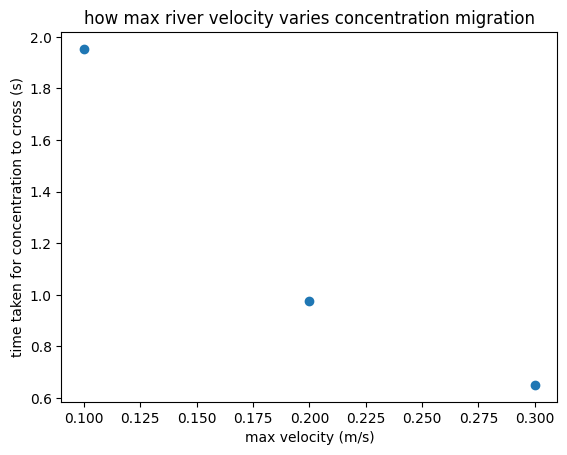

In [28]:
velocities = (0.1,0.2,0.3)
times = (1.953, 0.977, 0.651)

plt.figure()
plt.scatter(velocities, times)
plt.xlabel('max velocity (m/s)')
plt.ylabel('time taken for concentration to cross (s)')
plt.title('how max river velocity varies concentration migration')

plt.show()

this shows a negative correlation between river velcity and time to cross- showing that a faster river allows pollutant to spread across the river more effiently, possibly due to speeding up of eddies

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.